In [2]:
!pwd

/content


In [3]:
!git clone https://github.com/kairess/ACGPN.git

Cloning into 'ACGPN'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 165 (delta 21), reused 19 (delta 18), pack-reused 141
Receiving objects: 100% (165/165), 303.15 KiB | 3.09 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [4]:
%cd ACGPN

/content/ACGPN


dependencies 및 사전 파일 준비

In [5]:
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 4.7 MB/s eta 0:00:00


In [6]:
import gdown
import numpy as np
from PIL import Image
import IPython
import os
import sys
import time

from predict_pose import generate_pose_keypoints

In [7]:
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [8]:
#현재 위치 확인
!pwd

/content/ACGPN


In [9]:
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
!git clone https://github.com/levindabhi/U-2-Net.git

Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 769 (delta 72), reused 62 (delta 62), pack-reused 658
Receiving objects: 100% (769/769), 3.80 MiB | 18.43 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 822, done.
remote: Total 822 (delta 0), reused 0 (delta 0), pack-reused 822
Receiving objects: 100% (822/822), 30.72 MiB | 38.98 MiB/s, done.
Resolving deltas: 100% (379/379), done.


사전학습된 모델 다운로드

In [10]:
!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel

Downloading...
From (uriginal): https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
From (redirected): https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko&confirm=t&uuid=ffcc7703-df3c-4363-9d23-9dc64e2206a6
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:06<00:00, 31.0MB/s]


In [11]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
From (redirected): https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH&confirm=t&uuid=1e3bfea2-53c7-4cbe-8543-7d3d420c31a9
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:05<00:00, 44.8MB/s]


'lip_final.pth'

In [12]:
%cd U-2-Net

!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd ..

/content/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 211MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
From (redirected): https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ&confirm=t&uuid=8b1c78d2-8168-4c61-b0c2-127e51491e84
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:01<00:00, 131MB/s]
...load U2NEP---4.7 MB
/content/ACGPN


In [13]:
!mkdir checkpoints

gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From (uriginal): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
From (redirected): https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx&confirm=t&uuid=6dda90a2-4a7e-4994-91d4-7062c1df88bf
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:03<00:00, 157MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


옷 마스크 추출

In [14]:
sorted(os.listdir('inputs/cloth'))

['000066_1.jpg']

Generating mask for: cloth_1681205491.png
Saving output at Data_preprocessing/test_edge/cloth_1681205491.png


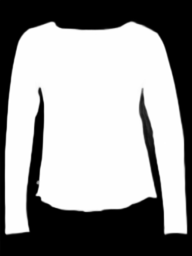

In [15]:
cloth_name = f'cloth_{int(time.time())}.png'

cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth'))[0])

cloth = Image.open(cloth_path)

cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')

cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

Image.open(f'Data_preprocessing/test_edge/{cloth_name}')

In [16]:
sorted(os.listdir('inputs/img'))

['000020_0.jpg']

In [17]:
img_name = f'img_{int(time.time())}.png'

img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])

img = Image.open(img_path)

img = img.resize((192,256), Image.BICUBIC)

img_path = os.path.join('Data_preprocessing/test_img', img_name)

img.save(img_path)

!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

generate_pose_keypoints(img_path, pose_path)

100% 1/1 [00:00<00:00,  2.03it/s]
File saved at Data_preprocessing/test_pose/img_1681205507_keypoints.json


In [18]:
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
    f.write(f'{img_name} {cloth_name}')

In [19]:
!python test.py

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

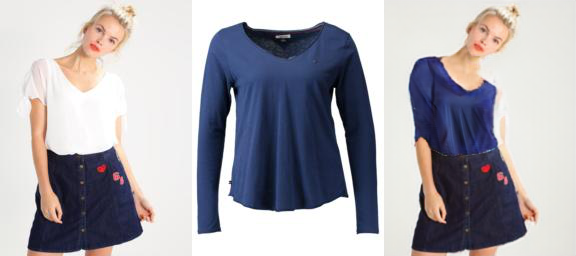

In [20]:
output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/{img_name}'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid

결과 이미지가 깔끔하지는 않지만, 저건 긴팔이고 특정 데이터에 해당하는 오류..이다.
반팔의 경우는 거의 다 잘 작동한다고 한다.